In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
import string
import re
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import StandardScaler,LabelEncoder
tokenizer=TweetTokenizer()

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train=pd.read_csv("./data/train.csv.zip")
test=pd.read_csv("./data/test.csv.zip")

In [3]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [4]:
test.head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [5]:
print train.shape
print test.shape

(159571, 8)
(153164, 2)


## clean comments

In [6]:
rowsum=train.iloc[:,2:].sum(axis=1)

In [7]:
train['clean']=(rowsum==0)

In [8]:
print "total comments: ",len(train)
print "total clean comments: ",sum(train["clean"])

total comments:  159571
total clean comments:  143346


## nan

In [9]:
print train.isnull().any()
print "_________________________"
print test.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
clean            False
dtype: bool
_________________________
id              False
comment_text    False
dtype: bool


In [10]:
train['comment_text'].fillna("unknown",inplace=True)
test["comment_text"].fillna("unknown",inplace=True)

## length of comments

In [11]:
length=train.comment_text.str.len()
print (length.mean(),length.std(),length.max(),length.min())

(394.7120842759649, 591.9907293798332, 5895, 6)


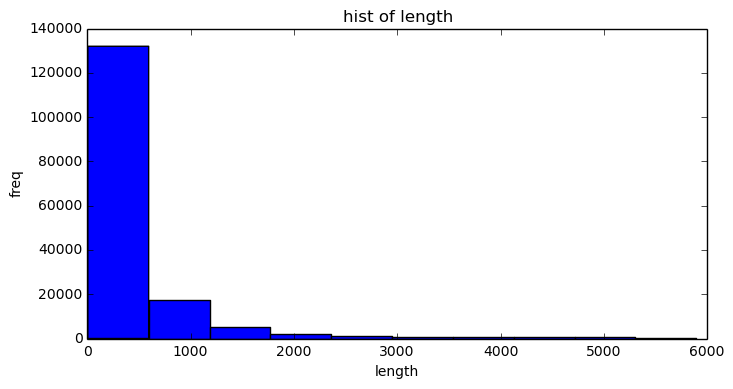

In [12]:
plt.figure(figsize=(8,4))
plt.hist(length)
plt.title("hist of length")
plt.xlabel("length")
plt.ylabel("freq")
plt.show()

## class

In [13]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True


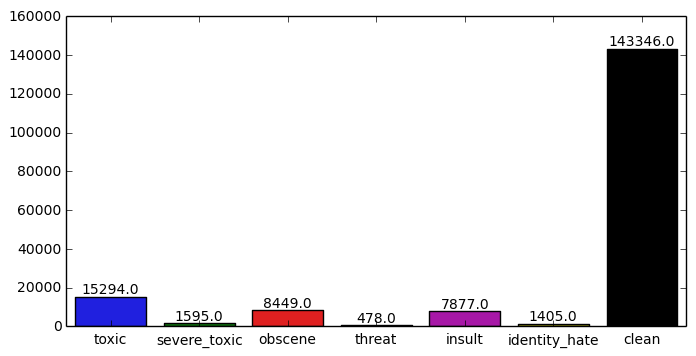

In [14]:
x=train.iloc[:,2:].sum(axis=0)
plt.figure(figsize=(8,4))
ax=sns.barplot(x.index,x.values)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

## multi-tags

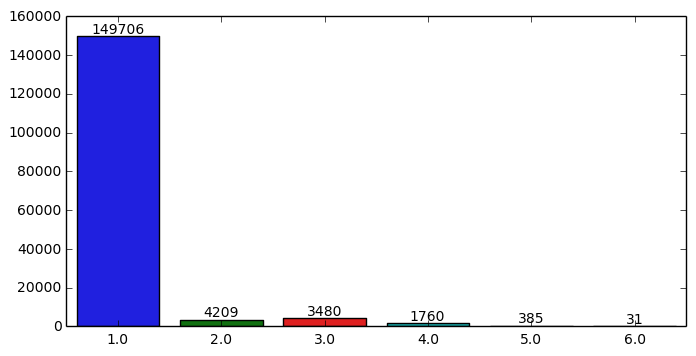

In [15]:
x=train.iloc[:,2:].sum(axis=1).value_counts()
plt.figure(figsize=(8,4))
ax=sns.barplot(x.index,x.values)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

## corr

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


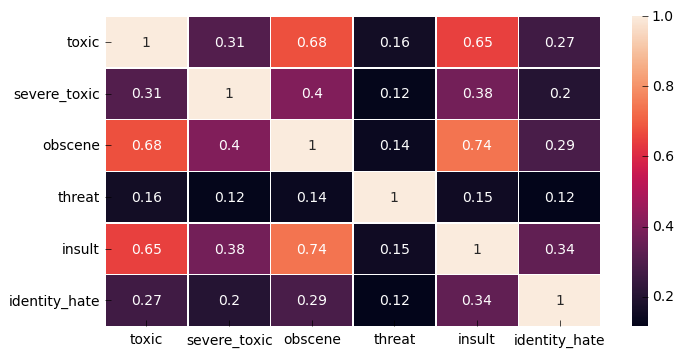

In [16]:
x=train.iloc[:,2:-1].corr()
plt.figure(figsize=(8,4))
sns.heatmap(x,annot=True,linewidths=0.1)

## comment example

In [17]:
train.iloc[2,1]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [18]:
train.iloc[10,1]

'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

## dev features

In [19]:
df = pd.concat([train.iloc[:,:2],test.iloc[:,:2]],axis=0)
df.shape

(312735, 2)

In [20]:
eng_stopwords=pd.read_csv(".//data/english stopwords",header=None)[0].tolist()
#count of sentences
df["count_sent"]=df["comment_text"].apply(lambda x: len(re.findall('\n',x))+1)
#count of words
df["count_w"]=df["comment_text"].apply(lambda x: len(x.split()))
#count of unique words
df["count_uniq_w"]=df["comment_text"].apply(lambda x:len(set(str(x).split())))
#count of letters
df["count_letter"]=df["comment_text"].apply(lambda x:len(str(x)))
#count of punctuations
df["count_punc"]=df["comment_text"].apply(lambda x:len( [p for p in str(x) if p in string.punctuation]   ))
#count of upper words
df["count_upper"]=df["comment_text"].apply(lambda x:len( [w for w in str(x).split() if w.isupper()]   ))
#count of title
df["count_title"]=df["comment_text"].apply(lambda x:len( [w for w in str(x).split() if w.istitle()]  ))
#count of stop words
df['count_stopword']=df["comment_text"].apply(lambda x:len( [w for w in str(x).split() if w.lower() in eng_stopwords]  ))
#mean of word length
df["mean_w_len"]=df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split() ]) )
#unique words percent
df["uniq_w_pct"]=df["count_uniq_w"]*100/df["count_w"]
#punc percent
df["punc_pct"]=df['count_punc']*100/df['count_w']

In [21]:
df=df.reset_index(drop=True)

## count_words and count_sentences

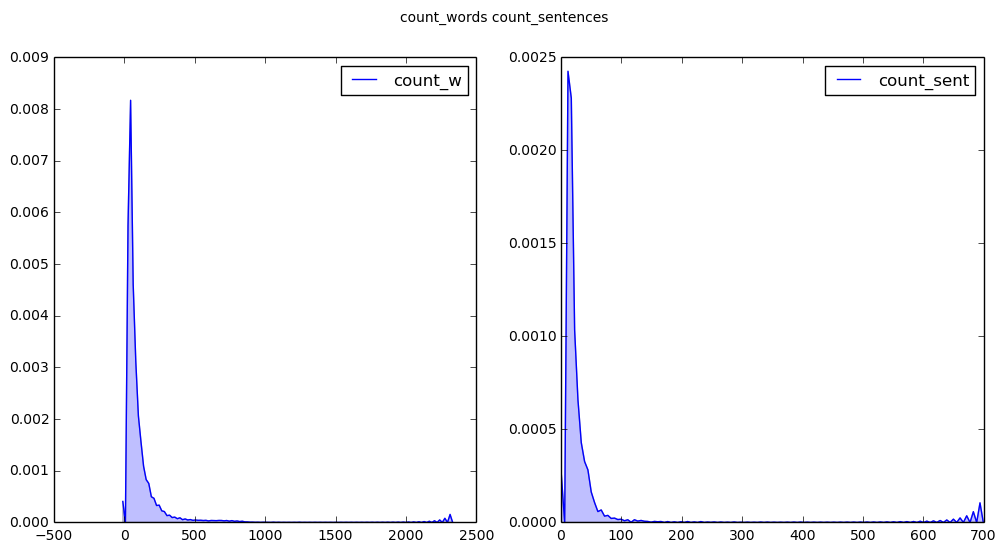

In [22]:
plt.figure(figsize=(12,6))
plt.suptitle("count_words count_sentences")
plt.subplot(121)
sns.kdeplot(df['count_w'],shade=True)
plt.subplot(122)
sns.kdeplot(df['count_sent'],shade=True)
plt.show()

## longer comments

In [23]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True


In [24]:
train_features=df.iloc[:len(train),:]
test_features=df.iloc[len(train):,:]
train_target=train.iloc[:,2:]
train_df=pd.concat([train_features,train_target],axis=1)
del df

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


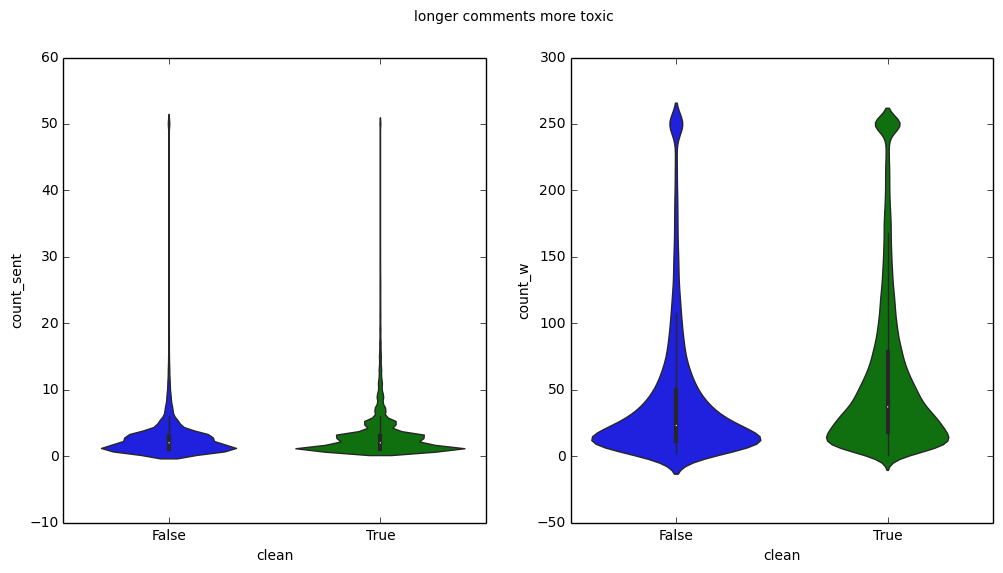

In [25]:
train_df['count_sent'].loc[train_df['count_sent']>50]=50
train_df["count_w"].loc[train_df["count_w"]>250]=250
plt.figure(figsize=(12,6))
plt.suptitle("longer comments more toxic")
plt.subplot(121)
sns.violinplot(x="clean",y="count_sent",data=train_df)
plt.subplot(122)
sns.violinplot(x="clean",y="count_w",data=train_df)

## corpus cleaning(appo,lem)

In [26]:
corpus=pd.concat([train['comment_text'],test["comment_text"]],axis=0)

In [27]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [28]:
lem = WordNetLemmatizer()
def clean(comment):
    comment = comment.lower()
    comment=re.sub("\\n","",comment)
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    clean_sent = " ".join(words)
    return (clean_sent)

In [29]:
import time
start=time.time()
corpus_clean=corpus.apply(lambda x: clean(x))
end=time.time()
print "time spent: ", int(end-start)

time spent:  326


## unigram - top 10 words

In [30]:
tfv=TfidfVectorizer(strip_accents="unicode",analyzer="word",ngram_range=(1,1),stop_words="english"
                   ,min_df=10,max_features=2000,use_idf=True,smooth_idf=True,sublinear_tf=True)
tfv.fit(corpus_clean)
features=np.array(tfv.get_feature_names())
train_unigram=tfv.transform(corpus_clean[:train.shape[0]])

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [31]:
def top_words(col):
    ids = train_df.index[train_df[col]==1]
    tf_mean=train_unigram[ids].toarray().mean(axis=0)
    top_ids=np.argsort(tf_mean)[::-1][:10]
    top_words=[(features[i],tf_mean[i]) for i in top_ids]
    df = pd.DataFrame(top_words)
    df.columns=['word','tfidf']
    return df

In [32]:
top_words('toxic')

,word,tfidf
0,fuck,0.088921
1,shit,0.027072
2,like,0.025106
3,suck,0.024409
4,wikipedia,0.020840
5,bitch,0.020326
6,ass,0.019996
7,stop,0.019436
8,stupid,0.019125
9,page,0.018929


In [33]:
top_words('insult')

,word,tfidf
0,fuck,0.128590
1,bitch,0.035461
2,shit,0.033654
3,suck,0.033434
4,ass,0.028391
5,asshole,0.026200
6,stupid,0.025801
7,faggot,0.025244
8,like,0.024709
9,idiot,0.023882


## Unigram and Bigram

In [34]:
tfv=TfidfVectorizer(strip_accents="unicode",analyzer="word",ngram_range=(1,2),stop_words="english"
                   ,min_df=10,max_features=500,use_idf=True,smooth_idf=True,sublinear_tf=True)
tfv.fit(corpus_clean)
features=np.array(tfv.get_feature_names())
train_ngrams =  tfv.transform(corpus_clean.iloc[:train.shape[0]])
test_ngrams = tfv.transform(corpus_clean.iloc[train.shape[0]:])

In [35]:
SELECTED_COLS=['count_sent', 'count_w', 'count_uniq_w',
       'count_letter', 'count_punc', 'count_upper',
       'count_title', 'count_stopword', 'mean_w_len',
       'uniq_w_pct', 'punc_pct']

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [36]:
temp=pd.concat([train_df[SELECTED_COLS],test_features[SELECTED_COLS]],axis=0)

In [37]:
for col in SELECTED_COLS:
    scaler=StandardScaler()
    scaled=scaler.fit_transform(temp[col])
    temp[col]=scaled

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preproc

In [38]:
df_train=pd.concat([temp.iloc[:len(train),:], pd.DataFrame(train_ngrams.toarray()),train[TARGET_COLS] ],axis=1)

In [39]:
test_features=test_features.reset_index(drop=True)
df_test=pd.concat([test_features[SELECTED_COLS],pd.DataFrame(test_ngrams.toarray())],axis=1)

In [40]:
del temp

In [41]:
print df_test.shape
print df_train.shape

(153164, 511)
(159571, 517)


## upsampling

In [42]:
"""
df_train['toxic'].value_counts()
"""

0    144277
1     15294
Name: toxic, dtype: int64

In [43]:
"""
def upsampling(feature,prop):
    train_dat_0s = df_train[df_train[feature]==0]
    train_dat_1s = df_train[df_train[feature]==1]
    rep_1 = [train_dat_1s for x in range(train_dat_0s.shape[0]/train_dat_1s.shape[0])]
    keep_1s = pd.concat(rep_1,axis=0)
    train_dat = pd.concat([keep_1s,train_dat_0s],axis=0)
    train_dat=train_dat.drop([i for i in TARGET_COLS if i!=feature],axis=1)
    return train_dat.sample(frac=1)
    #train,val = np.split(train_dat.sample(frac=1),[int(prop*len(train_dat))])
    #train.to_csv('train_%s.csv' % feature,header=False,index=False)
    #val.to_csv("val_%s.csv" % feature,header=False,index=False)
"""

In [44]:
"""
df_train_toxic=upsampling("toxic",0.8)
"""

In [49]:
"""
df_train_toxic.shape
"""

(281923, 512)

## modeling

In [44]:
print df_test.shape
print df_train.shape

(153164, 511)
(159571, 517)


In [45]:
df_test_labels = pd.read_csv('./data/test_labels.csv')

In [47]:
df_train.head()

,count_sent,count_w,count_uniq_w,count_letter,count_punc,count_upper,count_title,count_stopword,mean_w_len,uniq_w_pct,...,496,497,498,499,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,-0.218321,-0.210960,-0.091047,-0.195557,-0.160286,-0.044838,0.175138,-0.267327,0.019452,0.740751,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,-0.360810,-0.526149,-0.537973,-0.446687,-0.114454,-0.084789,-0.298072,-0.591159,0.076011,1.096802,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,-0.360810,-0.223082,-0.128291,-0.246774,-0.251949,-0.124739,-0.357223,-0.197934,-0.059165,0.550009,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,0.209146,0.637628,0.672451,0.395920,0.091788,0.075012,-0.061467,0.634776,-0.070425,-1.003270,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,-0.360810,-0.574640,-0.612461,-0.521035,-0.274865,-0.124739,-0.357223,-0.521766,-0.104452,1.096802,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [48]:
df_test.head()

,count_sent,count_w,count_uniq_w,count_letter,count_punc,count_upper,count_title,count_stopword,mean_w_len,uniq_w_pct,...,490,491,492,493,494,495,496,497,498,499
0,1,72,61,367,12,0,4,25,4.111111,84.722222,...,0.0,0.0,0.0,0.0,0.204664,0.0,0.0,0.0,0.0,0.0
1,3,12,11,50,6,1,2,5,3.000000,91.666667,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,5,12,10,56,8,0,4,1,3.083333,83.333333,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,1,38,30,205,6,3,4,21,4.421053,78.947368,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,1,7,7,41,2,1,1,2,5.000000,100.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in SELECTED_COLS:
    scaler=StandardScaler()
    scaled=scaler.fit_transform(df_test[col])
    df_test[col]=scaled

In [50]:
"""
scores = []
#submission = pd.DataFrame.from_dict({'id':df_test_labels['id']})
x = df_train.drop(TARGET_COLS,axis=1)
y = df_train[TARGET_COLS]
for class_name in TARGET_COLS:
    train_target = y[class_name]
    classifier = xgb.XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=6, 
                                    subsample=0.8, objective= "binary:logistic")   
    cv_score = np.mean(cross_val_score(classifier, x, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    #classifier.fit(x, train_target)
    #submission[class_name] = classifier.predict_proba(df_test)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))
"""

CV score for class toxic is 0.906615941473
CV score for class severe_toxic is 0.974422085747
CV score for class obscene is 0.947452958525
CV score for class threat is 0.944986984641
CV score for class insult is 0.924793461119
CV score for class identity_hate is 0.931962340165
Total CV score is 0.938372295278


In [51]:
"""
scores = []
#submission = pd.DataFrame.from_dict({'id':df_test_labels['id']})
x = df_train.drop(TARGET_COLS,axis=1)
y = df_train[TARGET_COLS]
for class_name in TARGET_COLS:
    train_target = y[class_name]
    classifier = xgb.XGBClassifier( learning_rate =0.1, n_estimators=500, max_depth=6, 
                                    subsample=0.8, objective= "binary:logistic")   
    cv_score = np.mean(cross_val_score(classifier, x, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    #classifier.fit(x,train_target)
    #submission[class_name] = classifier.predict_proba(df_test)[:, 1]
    #print class_name," Done"

print('Total CV score is {}'.format(np.mean(scores)))
"""

CV score for class toxic is 0.922452577218
CV score for class severe_toxic is 0.971989683353
CV score for class obscene is 0.953296734546
CV score for class threat is 0.935324119759
CV score for class insult is 0.933707459559
CV score for class identity_hate is 0.927477855572
Total CV score is 0.940708071668


In [ ]:
"""
## if binary result needed
y_pred=xgb_pred
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred
"""

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200,400,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
"""

In [ ]:
"""
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x, y)
"""